### Aneel Web Scraping - Python


Projeto de coleta de dados na web (Web Scraping) através de Python que desenvolvi para adquirir dados diretamente do site da ANEEL.

A coleta de dados na web, pode ser vista como uma forma de mineração que permite a extração de dados de sites da web convertendo-os em informação estruturada para posterior análise.

A idealização desse projeto deu-se inicio em conjunto ao meu colega Rômulo Delgado. Rômulo, na intenção de automatizar um quesito dentro do modelo financeiro que ele utiliza diariamente, precisava de informações das tensões nominais secundária por munício, essa informação está contida no site da ANEEL para cada município, ou seja, 5572 informações (incluindo Brasília e Fernando de Noronha) para serem capturadas e inseridas em seu modelo.

Humanamente essa atividade é possível, entretanto levaria horas para as informações serem capturadas e registradas e depois inseridas no modelo, com isso em mente sugeri a ele de fazer um script de um "robô" que teria o objetivo de fazer essa atividade de forma automatizada para ele, assim portanto, tornando essa atividade mais fácil, rápida e com reprodutibilidade, onde por exemplo se ele quiser ter essas informações atualizadas diariamente é possível ter em torno de 20 minutos através do script em Python.

A atividade do script é justamente passar por todos os municípios disponíveis no site, recolhendo a informação e salvando essa informação, a partir de todas as informações salvas, será feito uma etapa de limpeza dos dados e após essa etapa as informações são colocadas em um arquivo Excel criando assim uma simples base de dados.

### 0 | Importando as bibliotecas necessárias


In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import time
from tqdm import tqdm
from IPython.display import Image


### 1 | Aquisição dos estados

In [3]:
#Indicação da url que será processada, com ela é possível adquirir todos os estados.
#Defining the main url where the states can be storaged.

url_estados = "https://www2.aneel.gov.br/aplicacoes/srd/frmConcessionaria.cfm"

**Vamos entender aonde os estados estão localizados dentro do texto HTML, indo no site e olhando dentro do código fonte**

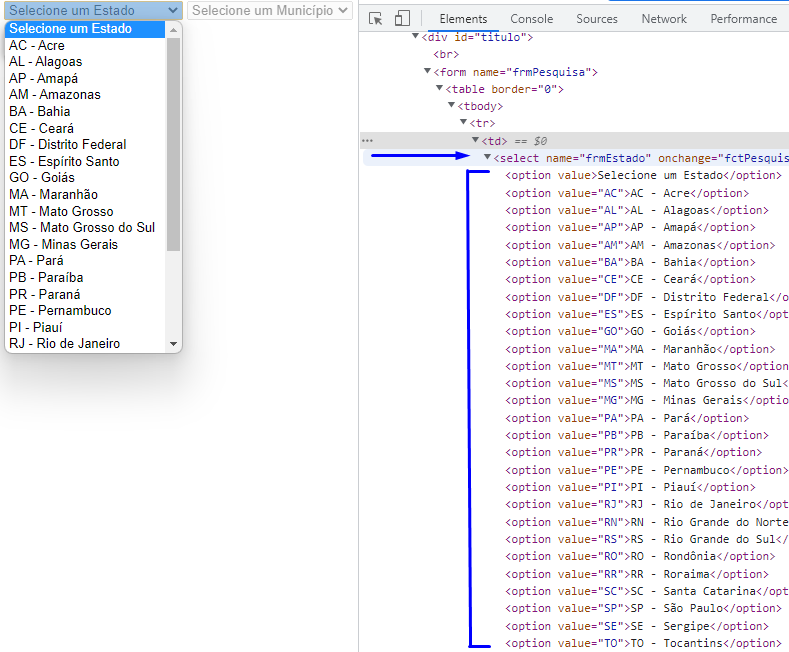

In [3]:
Image("Imagens/div_estados.png")

**Vamos requisitar a url através da biblioteca requests e a partir disso filtrar a parte do HTML desejada com a biblioteca bs4**

In [5]:
r_estados = requests.get(url_estados)

soup = BeautifulSoup(r_estados.text)

soup_estados = soup.find("select", {"name": "frmEstado"}).select("option[value]")
soup_estados


[<option value="">Selecione um Estado</option>,
 <option value="AC">AC - Acre</option>,
 <option value="AL">AL - Alagoas</option>,
 <option value="AP">AP - Amapá</option>,
 <option value="AM">AM - Amazonas</option>,
 <option value="BA">BA - Bahia</option>,
 <option value="CE">CE - Ceará</option>,
 <option value="DF">DF - Distrito Federal</option>,
 <option value="ES">ES - Espírito Santo</option>,
 <option value="GO">GO - Goiás</option>,
 <option value="MA">MA - Maranhão</option>,
 <option value="MT">MT - Mato Grosso</option>,
 <option value="MS">MS - Mato Grosso do Sul</option>,
 <option value="MG">MG - Minas Gerais</option>,
 <option value="PA">PA - Pará</option>,
 <option value="PB">PB - Paraíba</option>,
 <option value="PR">PR - Paraná</option>,
 <option value="PE">PE - Pernambuco</option>,
 <option value="PI">PI - Piauí</option>,
 <option value="RJ">RJ - Rio de Janeiro</option>,
 <option value="RN">RN - Rio Grande do Norte</option>,
 <option value="RS">RS - Rio Grande do Sul</optio

In [6]:
estados_ = [item.get('value') for item in soup_estados]
estados = list(filter(None, estados_))
print(estados)


['AC', 'AL', 'AP', 'AM', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MT', 'MS', 'MG', 'PA', 'PB', 'PR', 'PE', 'PI', 'RJ', 'RN', 'RS', 'RO', 'RR', 'SC', 'SP', 'SE', 'TO']


### 2 | Aquisição dos municípios com a lista de estados já adquirida

**A aquisição dos municípios funciona um pouco diferente do que foi feito com os estados. <br>A lista de municípios não está presente no HTML e é "desbloqueada" apenas quando o estado está selecionado e portanto essa lista é dinâmica. <br>A lista dos estados era estática e já estava presente no HTML.<br> Abaixo será mostrado como isso está dentro do HTML**

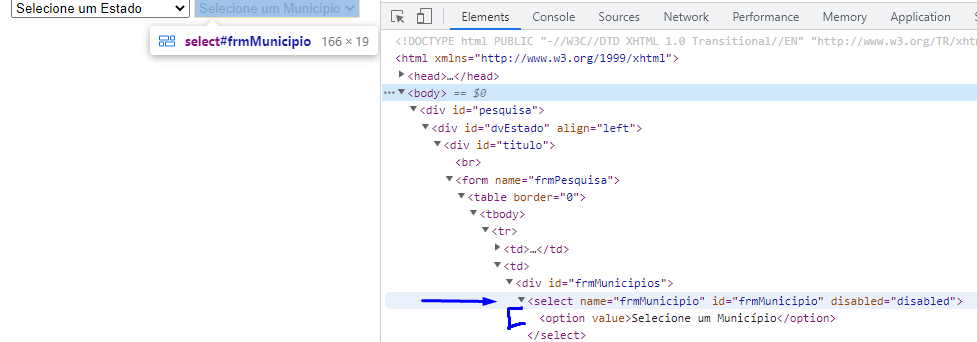

In [7]:
# Sem estados selecionado

Image("Imagens/div_municipios_vazio.png")

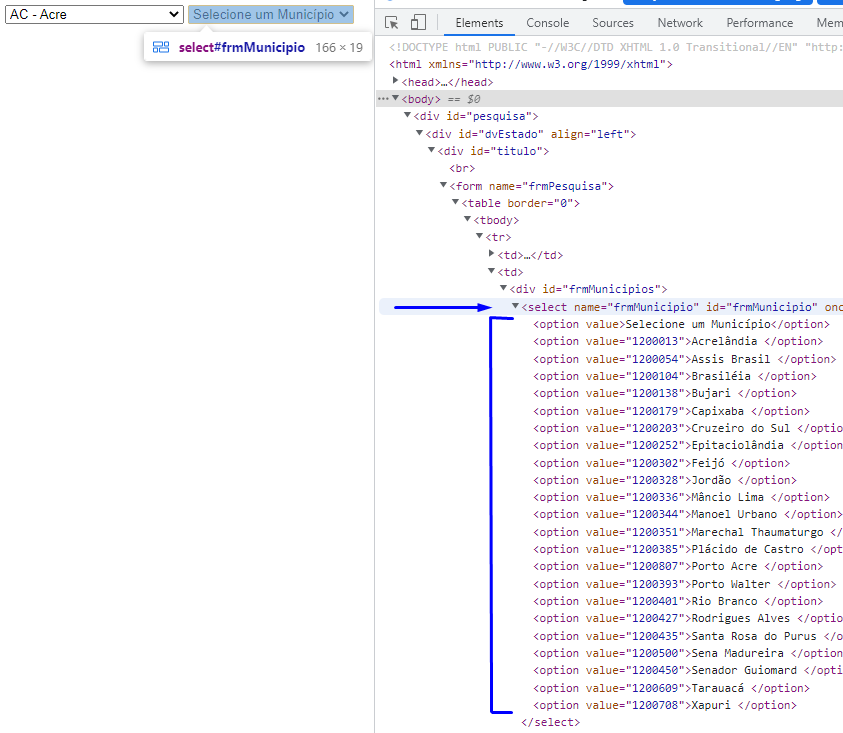

In [8]:
# Com estado selecionado
Image("Imagens/div_municipios.png")

**Vamos primeiro criar o código que irá salvar todos os municípios de 1 estado e depois reproduzir para todos os estados.<br>Essa etapa será semelhante ao que foi feito para o estado, onde vamos adquirir todas as opções possíveis.**

In [9]:
estado = "AC"
url_municipios = "https://www2.aneel.gov.br/aplicacoes/srd/dspMunicipios.cfm?municipio="+estado
r_municipios = requests.get(url_municipios)
soup_municipios = BeautifulSoup(r_municipios.text)
soup_municipios = soup_municipios.find("select", {"name": "frmMunicipio"}).select("option[value]")
soup_municipios

[<option value="">Selecione um Município</option>,
 <option value="1200013">Acrelândia                                   </option>,
 <option value="1200054">Assis Brasil                                 </option>,
 <option value="1200104">Brasiléia                                    </option>,
 <option value="1200138">Bujari                                       </option>,
 <option value="1200179">Capixaba                                     </option>,
 <option value="1200203">Cruzeiro do Sul                              </option>,
 <option value="1200252">Epitaciolândia                               </option>,
 <option value="1200302">Feijó                                        </option>,
 <option value="1200328">Jordão                                       </option>,
 <option value="1200336">Mâncio Lima                                  </option>,
 <option value="1200344">Manoel Urbano                                </option>,
 <option value="1200351">Marechal Thaumaturgo             

**Dentro da tag "option" temos 2 valores, o "value" e o "text", vamos salvar os valores como "id_municipios" e "municipios_", ignorando o valor vazio.**

In [10]:
id_municipios, municipios_ = [item["value"] for item in soup_municipios if item["value"] != ""], [item.text.strip() for item in soup_municipios if item["value"] != ""]

municipios = {municipios_[i]: id_municipios[i] for i in range(len(id_municipios))}
municipios


{'Acrelândia': '1200013',
 'Assis Brasil': '1200054',
 'Brasiléia': '1200104',
 'Bujari': '1200138',
 'Capixaba': '1200179',
 'Cruzeiro do Sul': '1200203',
 'Epitaciolândia': '1200252',
 'Feijó': '1200302',
 'Jordão': '1200328',
 'Mâncio Lima': '1200336',
 'Manoel Urbano': '1200344',
 'Marechal Thaumaturgo': '1200351',
 'Plácido de Castro': '1200385',
 'Porto Acre': '1200807',
 'Porto Walter': '1200393',
 'Rio Branco': '1200401',
 'Rodrigues Alves': '1200427',
 'Santa Rosa do Purus': '1200435',
 'Sena Madureira': '1200500',
 'Senador Guiomard': '1200450',
 'Tarauacá': '1200609',
 'Xapuri': '1200708'}

**Reprodução do que foi feito acima para apenas 1 estado para todos os estados, e salvando os resultados preliminares**

In [11]:
id_municipio_lista = []
municipio_lista = []
dicionario_municipio = {}

# Utilização do "tqdm" para visualizar o progresso do for loop

for estado in tqdm(estados):
    url_municipios = "https://www2.aneel.gov.br/aplicacoes/srd/dspMunicipios.cfm?municipio="+estado
    response_municipios = requests.get(url_municipios)
    soup_municipios = BeautifulSoup(response_municipios.text)
    options = soup_municipios.find("select", {"name": "frmMunicipio"}).select("option[value]")
    
    for option in options:
        if option["value"] == "":
            pass
        else: 
            municipio_lista.append(option.text.strip())
            id_municipio_lista.append(option["value"])
    
    # Para não sobrecarregar o site
    time.sleep(response_municipios.elapsed.total_seconds())

# Abaixo está o progresso de cada estado e quando tempo demorou cada iteração de estado para aquisição dos dados

100%|██████████| 27/27 [00:10<00:00,  2.47it/s]


In [12]:
dicionario_municipio = {id_municipio_lista[i]: municipio_lista[i] for i in range(len(municipio_lista))}

In [13]:
len(dicionario_municipio)

5574

In [14]:
#Quantidade de municípios encontrados
len(municipio_lista)

5574

A quantidade de 5574 municípios indica que estamos no caminho certo, entretanto temos **5572 municípios no Brasil**. <br>Esses 2 valores adicionais vão causar erros nos resultados mas serão tratados conforme necessidade. 

### 3 | Resultado preliminar para 1 município


**Por esse site ter sua resposta dinâmina, a URL utilizada previamente não será utilizada, <br> é necessário encontrar a URL que faz o request final para o resultado aparecer**

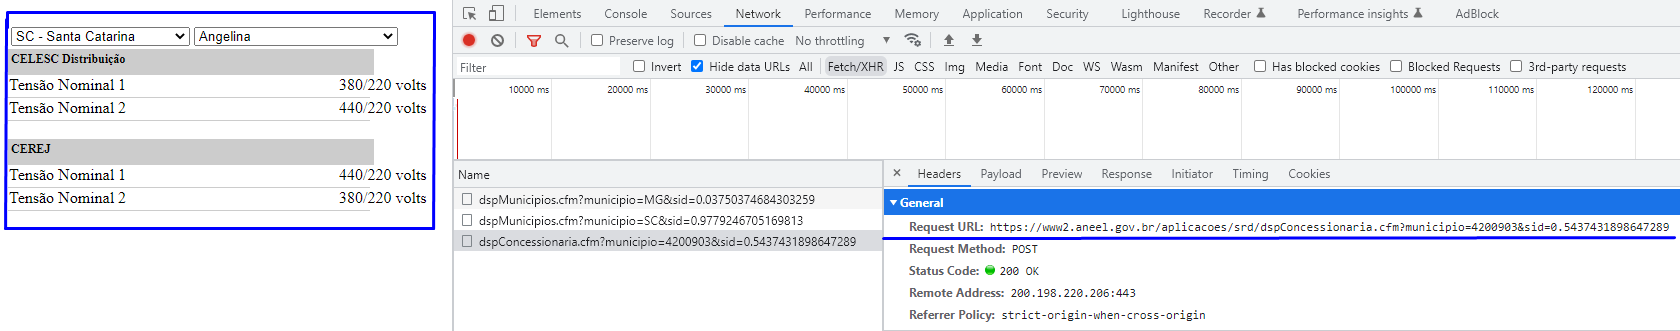

In [15]:
Image("Imagens/url_resultado.png")

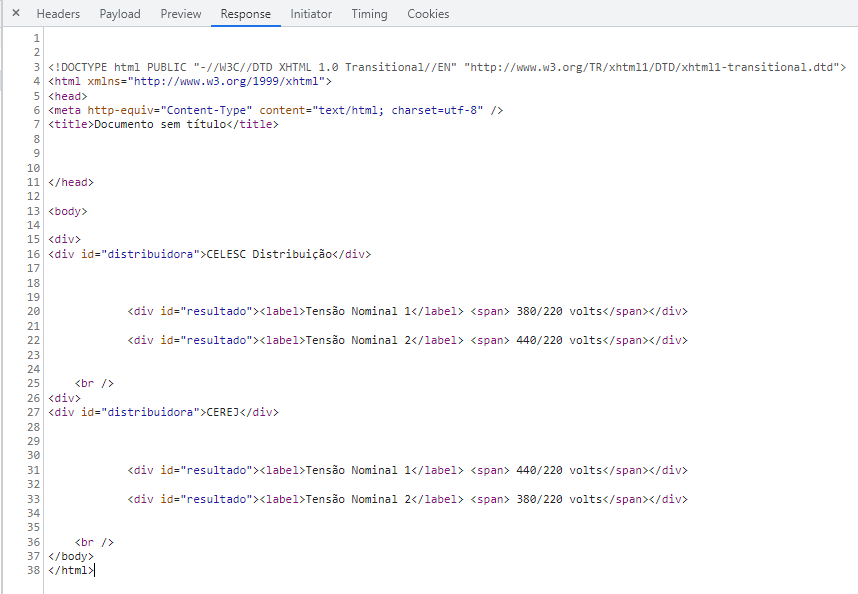

In [16]:
Image("Imagens/div_resultado.png")

**Os passos seguintes serão semelhantes aos que já foram feitos, onde estaremos tirando o texto HTML como resultado**

In [17]:
# ID do município da foto
frmMunicipio = '4200903'
url = 'https://www2.aneel.gov.br/aplicacoes/srd/dspConcessionaria.cfm'
payload = {
    'municipio': frmMunicipio}
r = requests.get(url, params=payload)
print(r.status_code)
print(r.url)


200
https://www2.aneel.gov.br/aplicacoes/srd/dspConcessionaria.cfm?municipio=4200903


In [18]:
#Texto HTML igual da imagem acima
soup = BeautifulSoup(r.text)
soup


<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">

<html xmlns="http://www.w3.org/1999/xhtml">
<head>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<title>Documento sem título</title>
</head>
<body>
<div>
<div id="distribuidora">CELESC Distribuição</div>
<div id="resultado"><label>Tensão Nominal 1</label> <span> 380/220 volts</span></div>
<div id="resultado"><label>Tensão Nominal 2</label> <span> 440/220 volts</span></div>
<br/>
<div>
<div id="distribuidora">CEREJ</div>
<div id="resultado"><label>Tensão Nominal 1</label> <span> 440/220 volts</span></div>
<div id="resultado"><label>Tensão Nominal 2</label> <span> 380/220 volts</span></div>
<br/>
</div></div></body>
</html>

In [19]:
resultado_distribuidora = soup.find_all("div", {"id": "distribuidora"})
resultado_tensao = soup.find_all("div", {"id": "resultado"})


In [20]:
for el in resultado_distribuidora:
    print(el.get_text())


CELESC Distribuição
CEREJ


In [21]:
for el in resultado_tensao:
    print(el.get_text())


Tensão Nominal 1  380/220 volts
Tensão Nominal 2  440/220 volts
Tensão Nominal 1  440/220 volts
Tensão Nominal 2  380/220 volts


### 4 | Utilizando todas as etapas para adquirir todos os resultados


In [22]:
# Indicar url resposável pela busca dos dados
url = 'https://www2.aneel.gov.br/aplicacoes/srd/dspConcessionaria.cfm'

# Criação do dicionário que será utilizado como resultado
resultado ={}

# Esse loop foi feito a partir dos passos acima, apenas a forma que os dados são guardados serão novidade
for estado in tqdm(estados):
    url_municipios = "https://www2.aneel.gov.br/aplicacoes/srd/dspMunicipios.cfm?municipio="+estado
    r_municipios = requests.get(url_municipios)
    soup_municipios = BeautifulSoup(r_municipios.text)
    id_municipio = soup_municipios.find_all("option")

    for id in tqdm(id_municipio):
        if id["value"] == "":
            pass
        else:
            payload = {'municipio': id["value"]}
            final_request = requests.get(url, params=payload, stream=False)
            soup = BeautifulSoup(final_request.text)
            resultado_distribuidora = soup.find_all("div", {"id": "distribuidora"})
            resultado_tensao = soup.find_all("div", {"id": "resultado"})
            
            # A criação de diversas listas pois o resultado de um município pode envolver diversas concessionárias e diversas tensões nominais.
            lista_da_lista = []
            lista1 = []
            lista2 = []
            lista3 = []
            lista4 = []
            lista5 = []
            lista6 = []
            
            # Criação de um suporte, a forma que os dados da tensão nominal estavam sendo adquiridos era
            # impossível saber de qual tensão era qual concessionária no mesmo município, com o suporte
            # os valores da tensão nominal vai para a outra lista quando o suporte muda de valor, e o valor
            # do suporte muda quando o próximo valor de "Tensão Nominal 1" é adquirido
            suporte = 0

            if resultado_tensao is None:
                pass
            else:
                for elem in resultado_tensao:
                    if "Tensão Nominal 1" in elem.get_text():  
                        suporte += 1
                    if suporte < 2:
                        lista1.append(elem.get_text())
                    if suporte >= 2 and suporte < 3:
                        lista2.append(elem.get_text())
                    if suporte >= 3 and suporte < 4:
                        lista3.append(elem.get_text())
                    if suporte >= 4 and suporte < 5:
                        lista4.append(elem.get_text())
                    if suporte >= 5 and suporte < 6:
                        lista5.append(elem.get_text())
                    if suporte >= 5 and suporte < 6:
                        lista6.append(elem.get_text())                                                                
                lista_da_lista.append(lista1)
                lista_da_lista.append(lista2)
                lista_da_lista.append(lista3)
                lista_da_lista.append(lista4)
                lista_da_lista.append(lista5)
                lista_da_lista.append(lista6)
                    
                dicionario_distribuidora = {}
                if resultado_distribuidora is None:
                    pass
                else:
                    for idx, elem in enumerate(resultado_distribuidora):
                        dicionario_distribuidora[elem.get_text()] = lista_da_lista[idx]
            
            resultado[id["value"]] = {"Estado": estado, "Concessionária": dicionario_distribuidora}

# Abaixo está o progresso de cada estado e quando tempo demorou cada iteração de estado para aquisição dos dados

100%|██████████| 27/27 [19:39<00:00, 43.70s/it]


In [23]:
# Caso queira ver o Pandas DataFram sem largura maxima para as colunas
pd.set_option('display.max_colwidth', None)

In [24]:
# Verificando o tamanho da resposta que tivemos, devemos ter 5574 como visto anteriormente, entretanto, notar que temos 5572 municípios no Brasil
print(len(resultado))

5574


### 5 | Tranformação dos resultados, possibilitanto a utilização dos dados para uma análise futura


**Os dados serão separados em dois dataframes pois as informações estão de forma "nested" onde uma informação está dentro da outra,<br> para obtermos os dados de forma completa e que possam ser lidos de maneira fácil, iremos trabalhar com 2 dataframes e depois juntando em 1.**

In [25]:
# Transformação do dicionário em um DataFrame
df_dicionario = pd.DataFrame(resultado)
df_dicionario.head()

,1200013,1200054,1200104,1200138,1200179,1200203,1200252,1200302,1200328,1200336,...,1720853,1720903,1720937,1720978,1721109,1721208,1721257,1721307,1722081,1722107
Estado,AC,AC,AC,AC,AC,AC,AC,AC,AC,AC,...,TO,TO,TO,TO,TO,TO,TO,TO,TO,TO
Concessionária,"{'Eletrobrás Distribuição Acre': ['Tensão Nominal 1 220/127 volts', 'Tensão Nominal 2 230/115 volts']}","{'Eletrobrás Distribuição Acre': ['Tensão Nominal 1 220/127 volts', 'Tensão Nominal 2 230/115 volts']}","{'Eletrobrás Distribuição Acre': ['Tensão Nominal 1 220/127 volts', 'Tensão Nominal 2 230/115 volts']}","{'Eletrobrás Distribuição Acre': ['Tensão Nominal 1 220/127 volts', 'Tensão Nominal 2 230/115 volts']}","{'Eletrobrás Distribuição Acre': ['Tensão Nominal 1 220/127 volts', 'Tensão Nominal 2 230/115 volts']}","{'Eletrobrás Distribuição Acre': ['Tensão Nominal 1 220/127 volts', 'Tensão Nominal 2 230/115 volts']}","{'Eletrobrás Distribuição Acre': ['Tensão Nominal 1 220/127 volts', 'Tensão Nominal 2 230/115 volts']}","{'Eletrobrás Distribuição Acre': ['Tensão Nominal 1 220/127 volts', 'Tensão Nominal 2 230/115 volts']}",{'Eletrobrás Distribuição Acre': ['Tensão Nominal 1 220/127 volts']},"{'Eletrobrás Distribuição Acre': ['Tensão Nominal 1 220/127 volts', 'Tensão Nominal 2 230/115 volts']}",...,"{'Energisa Tocantins (ETO)': ['Tensão Nominal 1 380/220 volts', 'Tensão Nominal 2 440/220 volts']}","{'Energisa Tocantins (ETO)': ['Tensão Nominal 1 380/220 volts', 'Tensão Nominal 2 440/220 volts']}","{'Energisa Tocantins (ETO)': ['Tensão Nominal 1 380/220 volts', 'Tensão Nominal 2 440/220 volts']}","{'Energisa Tocantins (ETO)': ['Tensão Nominal 1 380/220 volts', 'Tensão Nominal 2 440/220 volts']}","{'Energisa Tocantins (ETO)': ['Tensão Nominal 1 380/220 volts', 'Tensão Nominal 2 440/220 volts']}","{'Energisa Tocantins (ETO)': ['Tensão Nominal 1 380/220 volts', 'Tensão Nominal 2 440/220 volts']}","{'Energisa Tocantins (ETO)': ['Tensão Nominal 1 380/220 volts', 'Tensão Nominal 2 440/220 volts']}","{'Energisa Tocantins (ETO)': ['Tensão Nominal 1 380/220 volts', 'Tensão Nominal 2 440/220 volts']}","{'Energisa Tocantins (ETO)': ['Tensão Nominal 1 380/220 volts', 'Tensão Nominal 2 440/220 volts']}","{'Energisa Tocantins (ETO)': ['Tensão Nominal 1 380/220 volts', 'Tensão Nominal 2 440/220 volts']}"


In [26]:
# Arrumando o DataFrame para uma versão Tidy onde a leitura dos dados e transformações futuras sejam práticas

# Resetando o index Estado e Concessionária, para futura aplicação do método "Transpose", assim Estado e Concessionária serão Colunas
df_dicionario.reset_index(inplace=True)

# Aplicação do método "Transpose para leitura dos dados e transformações futuras sejam práticas"
df_dicionario = df_dicionario.transpose()

# Visualização dos dados
df_dicionario.head()

,0,1
index,Estado,Concessionária
1200013,AC,"{'Eletrobrás Distribuição Acre': ['Tensão Nominal 1 220/127 volts', 'Tensão Nominal 2 230/115 volts']}"
1200054,AC,"{'Eletrobrás Distribuição Acre': ['Tensão Nominal 1 220/127 volts', 'Tensão Nominal 2 230/115 volts']}"
1200104,AC,"{'Eletrobrás Distribuição Acre': ['Tensão Nominal 1 220/127 volts', 'Tensão Nominal 2 230/115 volts']}"
1200138,AC,"{'Eletrobrás Distribuição Acre': ['Tensão Nominal 1 220/127 volts', 'Tensão Nominal 2 230/115 volts']}"


In [27]:
# Atribuição da primeira linha do DataFrame como nome das colunas
df_dicionario = df_dicionario.rename(columns=df_dicionario.iloc[0]).drop(df_dicionario.index[0])

# Visualização dos dados
df_dicionario.head()

,Estado,Concessionária
1200013,AC,"{'Eletrobrás Distribuição Acre': ['Tensão Nominal 1 220/127 volts', 'Tensão Nominal 2 230/115 volts']}"
1200054,AC,"{'Eletrobrás Distribuição Acre': ['Tensão Nominal 1 220/127 volts', 'Tensão Nominal 2 230/115 volts']}"
1200104,AC,"{'Eletrobrás Distribuição Acre': ['Tensão Nominal 1 220/127 volts', 'Tensão Nominal 2 230/115 volts']}"
1200138,AC,"{'Eletrobrás Distribuição Acre': ['Tensão Nominal 1 220/127 volts', 'Tensão Nominal 2 230/115 volts']}"
1200179,AC,"{'Eletrobrás Distribuição Acre': ['Tensão Nominal 1 220/127 volts', 'Tensão Nominal 2 230/115 volts']}"


In [28]:
# Criação de uma coluna suporte para fazer o desmembramento do DataFrame no segundo DataFrame de Suporte
df_dicionario["Tensão"] = df_dicionario["Concessionária"]

#Separação do nome da concessionária com o restante do dicionário
df_dicionario = df_dicionario.explode("Concessionária")

# Resetando o index para futuro "join" com o segundo DataFrame
df_dicionario.reset_index(inplace = True)

# Na transformação acima, a coluna "index" é criada, o código abaixo renomea a coluna para o desejado
columns_name = {"index":"Município"}
df_dicionario = df_dicionario.rename(columns=columns_name, inplace = False)

# Visualização dos dados
df_dicionario.head()


,Município,Estado,Concessionária,Tensão
0,1200013,AC,Eletrobrás Distribuição Acre,"{'Eletrobrás Distribuição Acre': ['Tensão Nominal 1 220/127 volts', 'Tensão Nominal 2 230/115 volts']}"
1,1200054,AC,Eletrobrás Distribuição Acre,"{'Eletrobrás Distribuição Acre': ['Tensão Nominal 1 220/127 volts', 'Tensão Nominal 2 230/115 volts']}"
2,1200104,AC,Eletrobrás Distribuição Acre,"{'Eletrobrás Distribuição Acre': ['Tensão Nominal 1 220/127 volts', 'Tensão Nominal 2 230/115 volts']}"
3,1200138,AC,Eletrobrás Distribuição Acre,"{'Eletrobrás Distribuição Acre': ['Tensão Nominal 1 220/127 volts', 'Tensão Nominal 2 230/115 volts']}"
4,1200179,AC,Eletrobrás Distribuição Acre,"{'Eletrobrás Distribuição Acre': ['Tensão Nominal 1 220/127 volts', 'Tensão Nominal 2 230/115 volts']}"


In [29]:
#Criação do segundo DataFrame a partir do "Nested" dicionário, assim cada Tensão Nominal de cada município está separada por sua concessionária 
df_tensão = pd.json_normalize(df_dicionario['Tensão'].tolist()).add_prefix('')

# Visualização dos dados
df_tensão.head()

,Eletrobrás Distribuição Acre,Eletrobrás Distribuição Alagoas,CEA,Eletrobrás Distribuição Amazonas,COELBA,CEMIG Distribuição,SULGIPE,Enel Distribuição Ceará,CEB Distribuição,EDP Espírito Santo,...,CERNHE,Elektro,CERIS,CETRIL,CEDRAP,CERMC,CERIS,Energisa Sergipe (ESE),CERCOS,Energisa Tocantins (ETO)
0,"[Tensão Nominal 1 220/127 volts, Tensão Nominal 2 230/115 volts]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[Tensão Nominal 1 220/127 volts, Tensão Nominal 2 230/115 volts]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[Tensão Nominal 1 220/127 volts, Tensão Nominal 2 230/115 volts]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[Tensão Nominal 1 220/127 volts, Tensão Nominal 2 230/115 volts]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[Tensão Nominal 1 220/127 volts, Tensão Nominal 2 230/115 volts]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# Junção dos DataFrames de suporte
df_resultado = df_dicionario.join(df_tensão)

# Visualização dos dados
df_resultado.head()

,Município,Estado,Concessionária,Tensão,Eletrobrás Distribuição Acre,Eletrobrás Distribuição Alagoas,CEA,Eletrobrás Distribuição Amazonas,COELBA,CEMIG Distribuição,...,CERNHE,Elektro,CERIS,CETRIL,CEDRAP,CERMC,CERIS,Energisa Sergipe (ESE),CERCOS,Energisa Tocantins (ETO)
0,1200013,AC,Eletrobrás Distribuição Acre,"{'Eletrobrás Distribuição Acre': ['Tensão Nominal 1 220/127 volts', 'Tensão Nominal 2 230/115 volts']}","[Tensão Nominal 1 220/127 volts, Tensão Nominal 2 230/115 volts]",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1200054,AC,Eletrobrás Distribuição Acre,"{'Eletrobrás Distribuição Acre': ['Tensão Nominal 1 220/127 volts', 'Tensão Nominal 2 230/115 volts']}","[Tensão Nominal 1 220/127 volts, Tensão Nominal 2 230/115 volts]",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1200104,AC,Eletrobrás Distribuição Acre,"{'Eletrobrás Distribuição Acre': ['Tensão Nominal 1 220/127 volts', 'Tensão Nominal 2 230/115 volts']}","[Tensão Nominal 1 220/127 volts, Tensão Nominal 2 230/115 volts]",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1200138,AC,Eletrobrás Distribuição Acre,"{'Eletrobrás Distribuição Acre': ['Tensão Nominal 1 220/127 volts', 'Tensão Nominal 2 230/115 volts']}","[Tensão Nominal 1 220/127 volts, Tensão Nominal 2 230/115 volts]",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1200179,AC,Eletrobrás Distribuição Acre,"{'Eletrobrás Distribuição Acre': ['Tensão Nominal 1 220/127 volts', 'Tensão Nominal 2 230/115 volts']}","[Tensão Nominal 1 220/127 volts, Tensão Nominal 2 230/115 volts]",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# O método drop é utilizado para evitar informações duplicadas onde temos Concessionária e Tensão nos dois DataFrames de suporte
df_resultado.drop(["Concessionária","Tensão"],axis = 1, inplace = True)

# Visualização dos dados
df_resultado.head()

,Município,Estado,Eletrobrás Distribuição Acre,Eletrobrás Distribuição Alagoas,CEA,Eletrobrás Distribuição Amazonas,COELBA,CEMIG Distribuição,SULGIPE,Enel Distribuição Ceará,...,CERNHE,Elektro,CERIS,CETRIL,CEDRAP,CERMC,CERIS,Energisa Sergipe (ESE),CERCOS,Energisa Tocantins (ETO)
0,1200013,AC,"[Tensão Nominal 1 220/127 volts, Tensão Nominal 2 230/115 volts]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1200054,AC,"[Tensão Nominal 1 220/127 volts, Tensão Nominal 2 230/115 volts]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1200104,AC,"[Tensão Nominal 1 220/127 volts, Tensão Nominal 2 230/115 volts]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1200138,AC,"[Tensão Nominal 1 220/127 volts, Tensão Nominal 2 230/115 volts]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1200179,AC,"[Tensão Nominal 1 220/127 volts, Tensão Nominal 2 230/115 volts]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# Para os dados ficarem na versão Tidy novamente, deve ser aplicado uma tranformação dinâmica da tabela (Melt), assim os valores e atributos ficam da forma correta
df_resultado = df_resultado.melt(id_vars = ["Município","Estado"], var_name="Concessionária", value_name="Tensão")

# Visualização dos dados
df_resultado.head()

,Município,Estado,Concessionária,Tensão
0,1200013,AC,Eletrobrás Distribuição Acre,"[Tensão Nominal 1 220/127 volts, Tensão Nominal 2 230/115 volts]"
1,1200054,AC,Eletrobrás Distribuição Acre,"[Tensão Nominal 1 220/127 volts, Tensão Nominal 2 230/115 volts]"
2,1200104,AC,Eletrobrás Distribuição Acre,"[Tensão Nominal 1 220/127 volts, Tensão Nominal 2 230/115 volts]"
3,1200138,AC,Eletrobrás Distribuição Acre,"[Tensão Nominal 1 220/127 volts, Tensão Nominal 2 230/115 volts]"
4,1200179,AC,Eletrobrás Distribuição Acre,"[Tensão Nominal 1 220/127 volts, Tensão Nominal 2 230/115 volts]"


In [33]:
# Acima vemos que os dados de tensão estão corretos, entretanto, estão em formato de lista, aplicação do método "explode" para criar linhas novas para cada item da lista e cada linha ter um valor único
df_resultado = df_resultado.explode(["Tensão"])

# Visualização dos dados
df_resultado.head()

,Município,Estado,Concessionária,Tensão
0,1200013,AC,Eletrobrás Distribuição Acre,Tensão Nominal 1 220/127 volts
0,1200013,AC,Eletrobrás Distribuição Acre,Tensão Nominal 2 230/115 volts
1,1200054,AC,Eletrobrás Distribuição Acre,Tensão Nominal 1 220/127 volts
1,1200054,AC,Eletrobrás Distribuição Acre,Tensão Nominal 2 230/115 volts
2,1200104,AC,Eletrobrás Distribuição Acre,Tensão Nominal 1 220/127 volts


In [34]:
# Visualização dos valores nulos, a possibilidade de ter valor nulo a partir da tranformação "melt" e "explode" utilizada previamente
df_resultado.isna().sum()

Município              0
Estado                 0
Concessionária         0
Tensão            658259
dtype: int64

In [35]:
# Transformações de limpeza
df_resultado.dropna(inplace = True)
df_resultado.drop_duplicates(inplace = True)

# A partir do dicionário de município criado no "Item 2" podemos transformar os IDs de municíos em seus respectivos nomes
df_resultado=df_resultado.replace({"Município": dicionario_municipio})

# Visualização dos dados
df_resultado.shape

(11689, 4)

**Visualização dos resultados na web e no DataFrame**

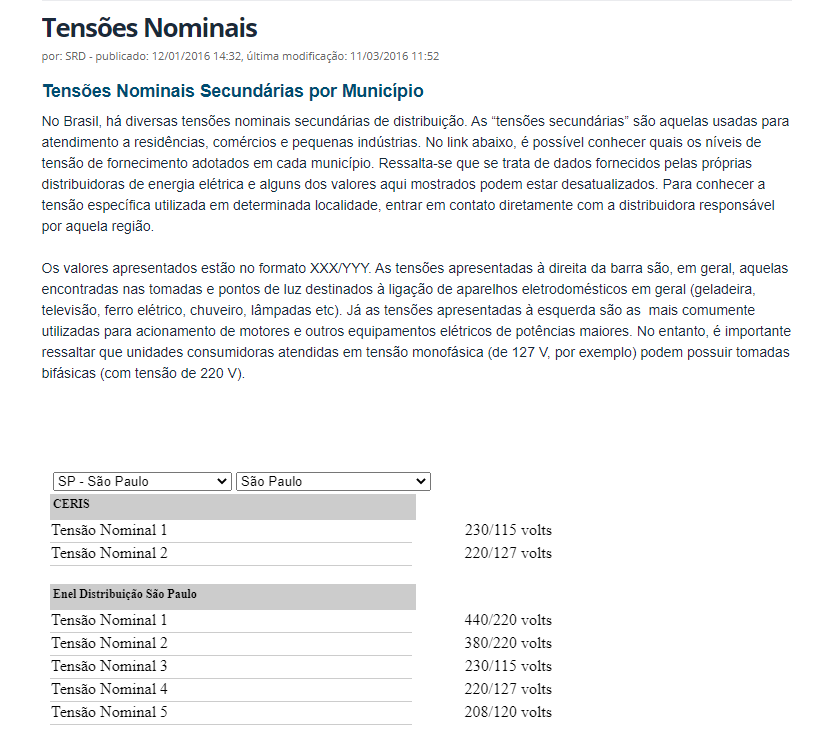

In [36]:
# Visualização da página web e seu resultado
Image("Imagens/Aneel Descrição.png")

In [37]:
# Visualização do DataFram, assim podemos comparar as resposta desejado com a obtida
df_resultado[df_resultado["Município"]=="São Paulo"]

,Município,Estado,Concessionária,Tensão
604597,São Paulo,SP,Enel Distribuição São Paulo,Tensão Nominal 1 440/220 volts
604597,São Paulo,SP,Enel Distribuição São Paulo,Tensão Nominal 2 380/220 volts
604597,São Paulo,SP,Enel Distribuição São Paulo,Tensão Nominal 3 230/115 volts
604597,São Paulo,SP,Enel Distribuição São Paulo,Tensão Nominal 4 220/127 volts
604597,São Paulo,SP,Enel Distribuição São Paulo,Tensão Nominal 5 208/120 volts
646940,São Paulo,SP,CERIS,Tensão Nominal 1 230/115 volts
646940,São Paulo,SP,CERIS,Tensão Nominal 2 220/127 volts


**Transformação do DataFrame de resultado em um arquivo Excel**

In [38]:
# Transformando o DataFrame em um arquivo Excel, a escolha do arquivo Excel foi feita pois as pessoas estão acostumadas com esse programa.
df_resultado.to_excel("python_resultados.xlsx")